# ShortRateModel Workbook
--- Nov-25-2019, Alan, Shaolun.du@gmail.com

This is a detailed documentation on Short Rate model with QuantLib implementation. In the following, I will go over three different types of Short Rate models and detailed on how to calibrate model volatility also how to use calibrated model to generate simulated rate path. The reason people tend to use short rate model comes from the usage of Monte-Carlo simulation in interests rate area. A short rate will generate a set of instaneous rates and link them together to get a full rate path. Different types of short rate model only distinguished by model assumption and calibration. After the calibration is done, only thing we need is to call the model several times to get a full set of short rates and link them together to generate a full rate path.

In this workbook, I will go over the following short rate model: 

- Vasicek model
\begin{equation}
dr_t = a(b - r_t) dt + \sigma dW_t
\end{equation}
- HullWhite model
\begin{equation}
dr_t = (\theta(t) - a r_t) dt + \sigma dW_t
\end{equation}
- CoxIngersollRoss model
\begin{equation}
dr_t = a(b - r_t) dt + \sigma\sqrt{r_t} dW_t
\end{equation}

Details on those model assumptions, logics and calculations are not covered in this workbook, if interestes in the math behind those models please refer to my other posts.

In the next part, I will talk about how to use the calibrated short rate model to generate rate path. This is an important step for monte-carlo method of derivative pricing.

*** NOTE: I will use USD curve as an example going forward, and I will talk about how to get other major currency curves as variantion to USD curves in the end. For XCS pricing, I will use USD/EUR cross currency swap as example.***

To start, please import the library:

In [1]:
import math
import numpy as np
import QuantLib as ql
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

Define USD term structure and swaption vol surface for all short rate model examples:

In [2]:
# <!-- collapse=True -->
# Helper function for curve building please refer to previous post
# Pull out a yield curve for pricing
# Details please refer to previous workbook, we will use USD LIBOR curve here.
Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.UnitedStates(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "Future":{ "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "ConVes_Adj":ql.QuoteHandle(ql.SimpleQuote(0.0)),# For convexity adjustment
               "Calendar":ql.UnitedStates(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.USDLibor(ql.Period(3,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(3,ql.Months),
              "FloatingLegFrequency":ql.Quarterly,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Semiannual,
              "FixedLegTenor":ql.Period(6,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.UnitedStates(),
            },
}
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
}
def Bootstrapping( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    futures  = Market["Future"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    futuresc_con  = Convention["Future"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    futuresHelpers = [ ql.FuturesRateHelper( ql.QuoteHandle(futures[d]),
                                             d, futuresc_con["LengthInMonths"],
                                             futuresc_con["Calendar"], futuresc_con["BsDay"],
                                             futuresc_con["EOM"], futuresc_con["DayCount"],
                                             futuresc_con["ConVes_Adj"])
                       for d in futures.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    yts.enableExtrapolation()
    return yts
# Generate USE LIBOR yield curve with TermStructure object
yts = Bootstrapping(Mkt_dict, Con_dict)
hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build discounting curve into a term structure
f_hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build forward curve term structure

In [3]:
# <!-- collapse=True -->
# Swaption vol data
# NOTE: for vol data it should be inline with the derivative need to pricing
# For example, if we want to price a 6 year swaption with short rate model then
# we should get all 6 year swaption vol data to calibrate (1X5,2X4,3X3,4X1,5X1)...
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility")
data = [CalibrationData(1, 5, 0.4502),
        CalibrationData(2, 4, 0.4414),
        CalibrationData(3, 3, 0.4458),
        CalibrationData(4, 2, 0.4275),
        CalibrationData(5, 1, 0.4260)]

In [4]:
# <!-- collapse=True -->
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(6,ql.Months) # underlying swap frequency
    fixed_leg_daycounter = ql.Thirty360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

def calibration_report(swaptions, data):
    print("-"*82)
    print("{:15s} {:15s} {:15s} {:15s} {:15s}".format("Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Error"))
    print("-"*82)
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error2*rel_error2
        
        print("{:15.5f} {:15.5f} {:15.5f} {:15.5f} {:15.5f}".format(model_price, black_price, implied_vol, market_vol, rel_error))

    print("-"*82)
    print("Cumulative Error : {:15.5f}".format(math.sqrt(cum_err)))

## Vasicek model

The model specifies that the instantaneous interest rate follows the stochastic differential equation:
\begin{equation}
dr_t = a(b - r_t) dt + \sigma dW_t
\end{equation}

where $W_t$ is a Wiener process under the risk neutral framework modelling the random market risk factor, in that it models the continuous inflow of randomness into the system. The standard deviation parameter, $\sigma^2$, determines the volatility of the interest rate and in a way characterizes the amplitude of the instantaneous randomness inflow. The typical parameters $b,,a\sigma$, together with the initial condition $r_{0}$, completely characterize the dynamics, and can be quickly characterized as follows, assuming $a$ to be non-negative:

- $b$: "long term mean level". All future trajectories of $r$ will evolve around a mean level $b$ in the long run;
- $a$: "speed of reversion". $a$ characterizes the velocity at which such trajectories will regroup around $b$ in time;
- $\sigma^2 $: "instantaneous volatility", measures instant by instant the amplitude of randomness entering the system. Higher $\sigma$  implies more randomness

The following derived quantity is also of interest,

- $\sigma ^{2}/(2a)$: "long term variance". All future trajectories of $r$ will regroup around the long term mean with such variance after a long time.

$a$ and $\sigma$  tend to oppose each other: increasing $\sigma$  increases the amount of randomness entering the system, but at the same time increasing $a$ amounts to increasing the speed at which the system will stabilize statistically around the long term mean $b$ with a corridor of variance determined also by $a$. This is clear when looking at the long term variance,

$\frac{\sigma ^{2}}{2a}$
which increases with $\sigma$  but decreases with $a$.

I will not calibrate this model here because the next model HullWhite 1F model is an extended version of Vasicek model. We will use the HullWhite model going forward.

In [5]:
# Vasicek model
today = ql.Date(18, 11, 2019);
settlement= ql.Date(20, 11, 2019);
ql.Settings.instance().evaluationDate = today;
term_structure = hyts
index = ql.USDLibor(ql.Period(3,ql.Months),f_hyts)
# Vasicek(Rate r0=0.05, Real a=0.1, Real b=0.05, Real sigma=0.01, Real lambda=0.0)
model = ql.Vasicek(0.05,0.1, 0.05, 0.01, 0.0)

## HullWhite model ( ext. Vasicek model)

One-factor model
The model is a short-rate model. In general, it has the following dynamics:
\begin{equation}
dr(t)=\left[\theta_t-\alpha_t r_t\right]\,dt+\sigma (t)\,dW(t)
\end{equation}
There is a degree of ambiguity among practitioners about exactly which parameters in the model are time-dependent or what name to apply to the model in each case. The most commonly accepted naming convention is the following:

- $θ$ has $t$ (time) dependence – the basic Hull–White model
- $θ$ and $α$ are both time-dependent – the extended Vasicek model

In [6]:
# HullWhite model
today = ql.Date(18, 11, 2019);
settlement= ql.Date(20, 11, 2019);
ql.Settings.instance().evaluationDate = today;
term_structure = hyts
index = ql.USDLibor(ql.Period(3,ql.Months),f_hyts)

model_HW = ql.HullWhite(term_structure)
engine = ql.JamshidianSwaptionEngine(model_HW)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model_HW.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model_HW.params()
print("a = {:6.5f}, sigma = {:6.5f}".format(a, sigma))

a = 0.01647, sigma = 0.00712


In [7]:
calibration_report(swaptions, data)

----------------------------------------------------------------------------------
Model Price     Market Price    Implied Vol     Market Vol      Rel Error      
----------------------------------------------------------------------------------
        0.01312         0.01322         0.44652         0.45020        -0.00804
        0.01473         0.01464         0.44428         0.44140         0.00631
        0.01344         0.01363         0.43907         0.44580        -0.01438
        0.01029         0.01015         0.43338         0.42750         0.01293
        0.00568         0.00566         0.42724         0.42600         0.00270
----------------------------------------------------------------------------------
Cumulative Error :         0.02313


## CIR model

The CIR model specifies that the instantaneous interest rate $r_{t}$ follows the stochastic differential equation, also named the CIR Process:

\begin{equation}
dr_{t}=a(b-r_{t})\,dt+\sigma \sqrt{r_{t}}\,dW_{t}
\end{equation}

where $W_{t}$ is a Wiener process (modelling the random market risk factor) and $a$, $b$, and $\sigma$, are the parameters. The parameter $a$ corresponds to the speed of adjustment to the mean $b$, and $\sigma$, to volatility. The drift factor, $a(b-r_{t})$, is exactly the same as in the Vasicek model. It ensures mean reversion of the interest rate towards the long run value $b$, with speed of adjustment governed by the strictly positive parameter $a$.

The standard deviation factor, $\sigma\sqrt{r_{t}}$, avoids the possibility of negative interest rates for all positive values of $a$ and $b$. An interest rate of zero is also precluded if the condition
$$2ab\geq \sigma ^{2}$$
is met. More generally, when the rate ($r_{t}$) is close to zero, the standard deviation ($\sigma \sqrt{r_{t}}$) also becomes very small, which dampens the effect of the random shock on the rate. Consequently, when the rate gets close to zero, its evolution becomes dominated by the drift factor, which pushes the rate upwards (towards equilibrium).

***Due to CIR model is not supported in PYTHON QuantLib, I will skip its calibration here. When it becomes available, I will update...***

## Rate Path Generation with HullWhite model

After calibration is done, we will get $a$ and $\sigma$ as inputs for HullWhite model. In this section, we will use another object called "ShortRateProcess" to generate rates path.

In [9]:
# Hull-White factor calibrated from short-rate model, see previous post
startDate = ql.Date(18, 11, 2019)
ql.Settings.instance().evaluationDate = startDate
a = 0.01647
sigma = 0.00712
volas = [ql.QuoteHandle(ql.SimpleQuote(sigma)),
         ql.QuoteHandle(ql.SimpleQuote(sigma))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(a))]
model = ql.Gsr(hyts, [startDate+100], volas, meanRev )
process = model.stateProcess()
# Define evaluation grid
date_grid = [startDate + ql.Period(i,ql.Months) for i in range(0,12*6)]
date_grid = np.sort(np.unique(date_grid))
time_grid = np.vectorize(lambda x: ql.ActualActual().yearFraction(startDate, x))(date_grid)
delta = time_grid[1:] - time_grid[:-1]
# Random number generator
seed = 1
urng = ql.MersenneTwisterUniformRng(seed)
usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

<h4>Generate N Pahts</h4>

In [10]:
# Generate N paths
N = 2000
x = np.zeros((N, len(time_grid))) # Zero Rates paths
y = np.zeros((N, len(time_grid)))
# Zero bond maturities
pillars = np.array([0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
zero_bonds = np.zeros((N, len(time_grid), len(pillars)))
for j in range(12):
    zero_bonds[:, 0, j] = model.zerobond(pillars[j], 0, 0)
for n in range(0,N):
    dWs = generator.nextSequence().value()
    for i in range(1, len(time_grid)):
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        x[n,i] = process.expectation( t0, x[n,i-1], delta[i-1]) \
                + dWs[i-1] * process.stdDeviation( t0, x[n,i-1], delta[i-1])
        y[n,i] = (x[n,i] - process.expectation(0,0,t1)) / process.stdDeviation(0,0,t1)
        for j in range(12):
            zero_bonds[n, i, j] = model.zerobond(t1+pillars[j], t1, y[n, i])

<h4>Quick View on Generated paths</h4>

Text(0.5, 1.0, 'Quick Look for HW Rate Paths.')

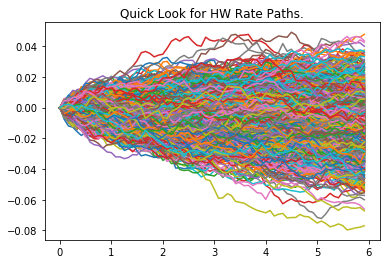

In [11]:
# plot the paths
for i in range(0,N):
    plt.plot(time_grid, x[i,:])
plt.title("Quick Look for HW Rate Paths.")

***Now, build simulated path into a termstructure handler that can directly feed in pricing model.***

In [12]:
#Swap pricing under each scenario
curves_dfs = []
for p in range(0,N):
    for t in range(0, len(date_grid)):
        date = date_grid[t]
        ycDates =  [ date, date + ql.Period(6, ql.Months) ] 
        ycDates += [ date + ql.Period(i,ql.Years) for i in range(1,11) ]
        yc = ql.DiscountCurve(ycDates, 
                              zero_bonds[p, t, :], 
                              ql.Actual365Fixed())
        yc.enableExtrapolation()
        curves_dfs.append(yc)

## Summary

In the above notebook, I talked about how to generate short rate model and rebuild short rates into actualt discounting curves. There are multiple models for short rate generation, however, they only difference in SDE(stochastic differential equation). After change SDE one can easily calibrate a different model into volatility surface and then generate discounting curves. Please pay attention to the following key points:
<span>
<font color='blue'>
    
- Model calibration should use ATM swaption volatility data with diagonal volatilities. Meaning, if you want to price a 7 year maturity swap's CVA, you should input 1X6,2X5... set of volatilities data. 

- After model calibration, we should start build zero curves and discounting curves. In my example, I am using X[..] variable to store zero rates and discounting curves are generated based on different starting points and maturities. The reason behind this is later we will use swap discounting engine to do pricing.

- Please pay special attention to discounting curves generation, we are actually using model formula starting from raw to generate a set of normal variables and link them together to get a discounting curve. Also we twitched the starting point using ZeroBond function.
</span>

**Summary QA**:

- **Why we need to build discounting curves cube instead of matrix?**
A: This is actualy a drawback using QuantLib, since this library does not allow the calcualtion on future dates with a fixed underlying yield curve. After building different discounting curves with different starting point(value points) we can use swap discounting engine to get its value.

- **Can I use different short rate models?**
A: Yes, of course. Because this implementation version I used the raw random number generator and manually linked them together to get discounting curves. You can change the zerobond generation code to incorporate a different model. However, I still need use QuantLib to calibrate the new short rate model's paramaters. I could not find out more about other models calibration online, and I will keep using Hull-White model sicne it is good enough to use in daily work.